In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Loading data

In [2]:
# the stocks we are going to consider
stock1 = 'EWA' # x
stock2 = 'EWC' # y

stocks = [stock1, stock2]

In [3]:
# define start and end dates
start_date = '2006-04-26'
end_date = '2012-04-09'

In [4]:
# download of the data
stock_df = yf.download(stocks, start = start_date, end = end_date)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [5]:
stock_df

,EWA,EWC
Date,,
2006-04-26,10.541416,18.149839
2006-04-27,10.483761,18.025776
2006-04-28,10.541416,18.142536
2006-05-01,10.642311,18.222807
2006-05-02,10.632704,18.419855
...,...,...
2012-03-30,14.834856,22.830433
2012-04-02,14.910572,23.201006
2012-04-03,14.677103,22.854603


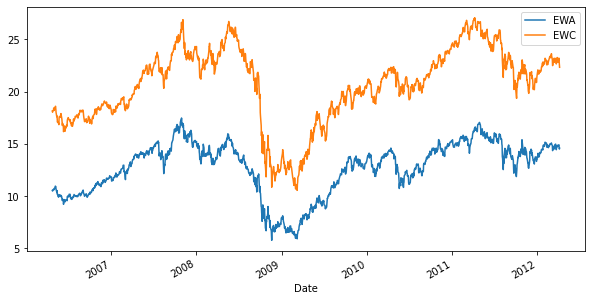

In [6]:
stock_df.plot(figsize=(10, 5))
plt.show()

<AxesSubplot:xlabel='Date'>

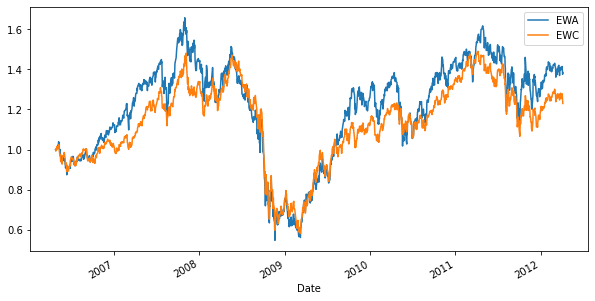

In [7]:
(stock_df / stock_df.iloc[0]).plot(figsize=(10,5))

## Evaluate stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

def stationarity(a, cutoff = 0.05):
    a = np.ravel(a)
    if adfuller(a)[1] < cutoff:
        print('The series is stationary')
        print('p-value = ', adfuller(a)[1])
    else:
        print('The series is NOT stationary')
        print('p-value = ', adfuller(a)[1])
        
def cointegration(a, b):
    if coint(a, b)[1] < 0.05:
        print('The series are cointegrated')
        print('p-value = ', coint(a, b)[1])
    else:
        print('The series are NOT cointegrated')
        print('p-value = ', coint(a, b)[1])

In [9]:
stationarity(stock_df[stock2])

The series is NOT stationary
p-value =  0.3355446163550947


In [10]:
cointegration(stock_df[stock2], stock_df[stock1])

The series are NOT cointegrated
p-value =  0.06754119070231808


## Linear Regression

In [11]:
slope, intercept, r, p, se = linregress(stock_df[stock1], stock_df[stock2])

In [12]:
print(slope, intercept)

1.3599146392023373 3.3546168770500735


In [13]:
y = slope * stock_df[stock1] + intercept

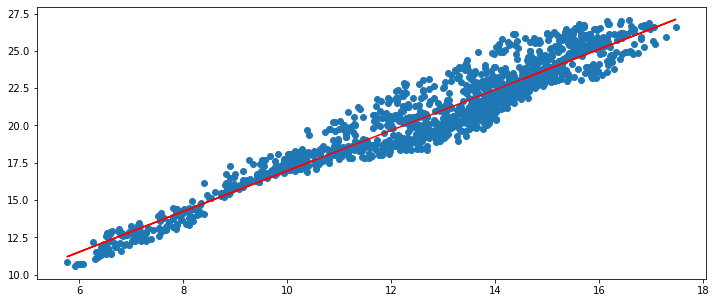

In [14]:
plt.figure(figsize=(12,5))
plt.scatter(stock_df[stock1], stock_df[stock2])
plt.plot(stock_df[stock1], y, 'r-')

$ stock2 = \alpha * stock1 + \beta $

In [15]:
hedge_ratio = stock_df[stock2] - slope * stock_df[stock1]

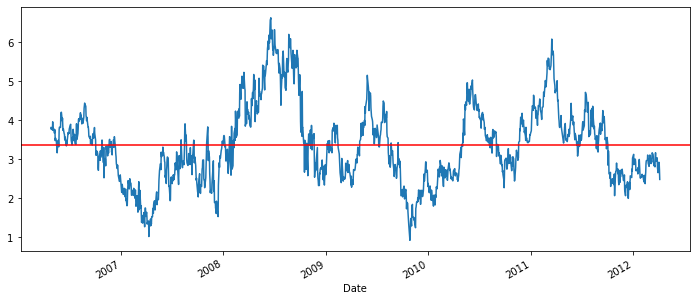

In [16]:
plt.figure(figsize=(12,5))
hedge_ratio.plot()
plt.axhline(y=intercept, color='r', linestyle='-')

## Kalman Filter

* Estimation of slope by Kalman filter
* Evaluation of hedge ratio using the slope values
* We have two states: slope and intercept
* The z is stock2 and H has stock1

Based on: https://medium.com/analytics-vidhya/understanding-and-implementing-kalman-filter-in-python-for-pairs-trading-9b8986d79b2d

In [17]:
class MyKalmanFilter:
    
    def __init__(self, delta, R):
        # measurement noise variance
        self.R = R

        # co-variance of process noise(2 dimensions)
        self.Q = delta / (1-delta) * np.eye(2)

        # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
        self.x = np.zeros((2, 1)) # np.array([[slope], [intercept]])     

        # state covariance
        self.P = np.zeros((2,2))     

    def step_forward(self, stock2, stock1):
        # Before entering the equations, let's define H as (1, 2) matrix
        H = np.array([stock1, 1])[None]
        # and define z
        z = stock2

        ## TIME UPDATE ##
        # first thing is to predict new state as the previous one (2x1)
        x_hat = self.x[:, -1][..., None]

        # then, the uncertainty or covariance prediction 
        P_hat = self.P + self.Q

        ## MEASUREMENT UPDATE ##
        # calc the Kalman gain
        K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

        # state update part 1 (measurement estimation)
        z_hat = H.dot(x_hat)
        # state update part 2
        x = x_hat + K.dot(z-z_hat)

        # uncertainty update
        self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

        # append the new state to the vector
        self.x = np.concatenate([self.x, x], axis=1)
        
        Q_var = (H.dot(P_hat.dot(H.T))+self.R)

        return self.x, z_hat, Q_var

mkf = MyKalmanFilter(delta=1e-4, R=1e-3)
error = []
sqrtQ = []
for idx, row in stock_df.iterrows():
    x, z_hat, Q_var = mkf.step_forward(row[stock2], row[stock1])
    error.append(row[stock2] - z_hat.squeeze())
    sqrtQ.append(np.sqrt(Q_var.squeeze()))

In [18]:
stock_df['hedge_ratio'] = x[0,1:]
stock_df['spread'] = x[1,1:]

# Trading Strategy
Source: Chan, E., 2016. Algorithmic Trading. Hoboken, N.J.: Wiley - pag 97

In [19]:
stock_df['hedge_ratio'] = x[0,1:]
stock_df['spread'] = x[1,1:]

Text(0.5, 1.0, 'slope')

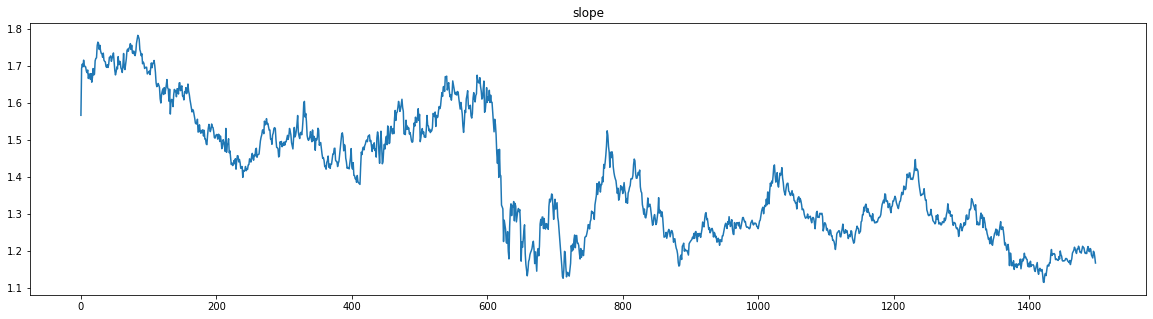

In [20]:
plt.figure(figsize=(20,5))
plt.plot(x[0,1:])
plt.title('slope')

Text(0.5, 1.0, 'intercept')

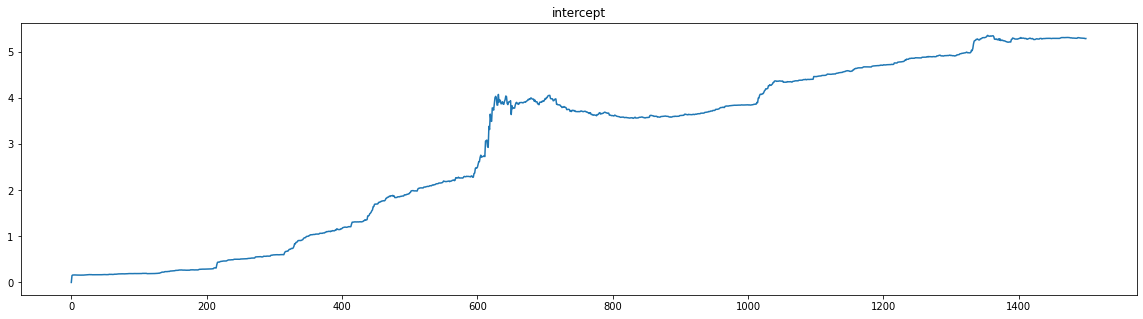

In [21]:
plt.figure(figsize=(20,5))
plt.plot(x[1,:])
plt.title('intercept')

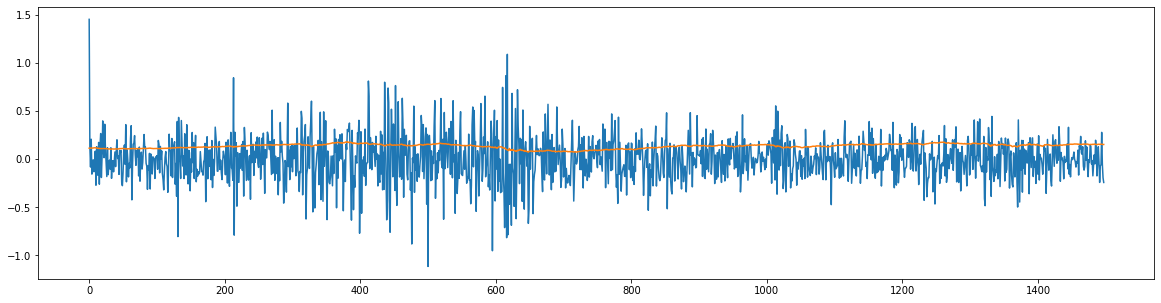

In [22]:
plt.figure(figsize=(20,5))
plt.plot(error[1:])
plt.plot(sqrtQ[1:])

In [23]:
stock_df['sqrtQ'] = sqrtQ
stock_df['e'] = error

We will buy this spread when the deviation is very negative, and vice versa if
it is very positive. How negative or positive? That depends on the predicted standard deviation of e(t), which is none other than sqrt Q (t).

In [24]:
stock_df['long_entry'] = (stock_df['e'] < -stock_df['sqrtQ'])
stock_df['long_exit'] = (stock_df['e'] > -stock_df['sqrtQ'])
stock_df['num_units_long'] = np.nan 
stock_df.loc[stock_df['long_entry'],'num_units_long'] = 1 
stock_df.loc[stock_df['long_exit'],'num_units_long'] = 0 
stock_df['num_units_long'][0] = 0 
stock_df['num_units_long'] = stock_df['num_units_long'].fillna(method='pad')

stock_df['short_entry'] = (stock_df['e'] > stock_df['sqrtQ'])
stock_df['short_exit'] = (stock_df['e'] < stock_df['sqrtQ'])
stock_df['num_units_short'] = np.nan 
stock_df.loc[stock_df['short_entry'],'num_units_short'] = -1
stock_df.loc[stock_df['short_exit'],'num_units_short'] = 0
stock_df['num_units_short'][0] = 0
stock_df['num_units_short'] = stock_df['num_units_short'].fillna(method='pad')

stock_df['numUnits'] = stock_df['num_units_long'] + stock_df['num_units_short']

/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3537/4267076259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_long'][0] = 0
/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3537/4267076259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_short'][0] = 0


## Evaluate positions based on the units

In [25]:
cols = [stock1, stock2]
temp1 = np.concatenate((stock_df['numUnits'].values.reshape(len(stock_df),1), stock_df['numUnits'].values.reshape(len(stock_df),1)), axis=1)
temp2 = np.ones((len(stock_df), 2))
temp2[:, 0] = -stock_df['hedge_ratio']

position = np.multiply(np.multiply(temp1, temp2), stock_df[cols].values)
position

array([[ -0.        ,   0.        ],
       [ 17.7532938 , -18.02577591],
       [ 17.97074965, -18.14253616],
       ...,
       [ -0.        ,   0.        ],
       [-17.1683522 ,  22.45180511],
       [-17.03886637,  22.32291222]])

## Returns from the strategy

In [26]:
returns = stock_df[cols].pct_change()
positions = pd.DataFrame(data=position,index = returns.index, columns=cols)
pnl = (returns * positions.shift(1)).sum(axis=1) # profit and loss
mkt_value = np.sum(abs(positions.shift(1).values), axis=1)
ret = pnl / mkt_value
ret = pd.DataFrame(ret).fillna(method='pad')
cum_prod = ((1 + ret).cumprod() - 1) # cumulative return
cum_prod

,0
Date,
2006-04-26,NaN
2006-04-27,NaN
2006-04-28,-0.000535
2006-05-01,0.002004
2006-05-02,0.004549
...,...
2012-03-30,2.766102
2012-04-02,2.760896
2012-04-03,2.766966


<AxesSubplot:xlabel='Date'>

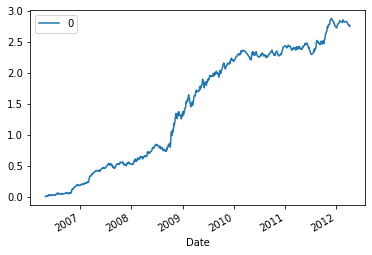

In [27]:
cum_prod.plot()

# Kalman filter using pykalman

In [28]:
from pykalman import KalmanFilter

def calc_slope_intercept_kalman(etfs, prices):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-4
    R = 1e-3
    Q = delta / (1 - delta) * np.eye(2) 
    H = np.vstack(
        [prices[etfs[1]], np.ones(prices[etfs[1]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, # len(y)
        n_dim_state=2, # len(x)
        initial_state_mean=np.zeros(2), # x0
        initial_state_covariance=np.ones((2, 2)), # P0
        transition_matrices=np.eye(2), # A
        observation_matrices=H, # H
        observation_covariance=R, # R
        transition_covariance=Q # Q
    )
    
    state_means, state_covs = kf.filter(prices[etfs[0]].values)
    return state_means, state_covs    
    

def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filte calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()

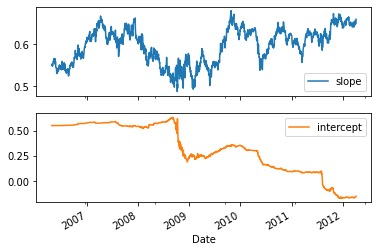

In [29]:
state_means, state_covs = calc_slope_intercept_kalman(stocks, stock_df)
draw_slope_intercept_changes(stock_df, state_means)

## Trading implementation with spread

In [30]:
def trading_strategy(spread, hedge_ratio):
    entryZscore = 1
    exitZscore = 0
    stock_df['spread'] = spread
    stock_df['hr'] = hedge_ratio
    stock_df['zScore'] = (stock_df['spread'] - stock_df['spread'].mean()) / stock_df['spread'].std()
    
    stock_df['long_entry'] = ((stock_df.zScore < - entryZscore) & ( stock_df.zScore.shift(1) > - entryZscore))
    stock_df['long_exit'] = ((stock_df.zScore > - exitZscore) & (stock_df.zScore.shift(1) < - exitZscore))
    stock_df['num_units_long'] = np.nan 
    stock_df.loc[stock_df['long_entry'],'num_units_long'] = 1 
    stock_df.loc[stock_df['long_exit'],'num_units_long'] = 0 
    stock_df['num_units_long'][0] = 0 
    stock_df['num_units_long'] = stock_df['num_units_long'].fillna(method='pad')

    stock_df['short_entry'] = ((stock_df.zScore > entryZscore) & ( stock_df.zScore.shift(1) < entryZscore))
    stock_df['short_exit'] = ((stock_df.zScore < exitZscore) & (stock_df.zScore.shift(1) > exitZscore))
    stock_df['num_units_short'] = np.nan 
    stock_df.loc[stock_df['short_entry'],'num_units_short'] = -1
    stock_df.loc[stock_df['short_exit'],'num_units_short'] = 0
    stock_df['num_units_short'][0] = 0
    stock_df['num_units_short'] = stock_df['num_units_short'].fillna(method='pad')

    stock_df['numUnits'] = stock_df['num_units_long'] + stock_df['num_units_short']
    
    #set up totals: num units and returns
    stock_df['spread_pct_ch'] = (stock_df['spread'] - stock_df['spread'].shift(1)) / ((stock_df[stock1] * abs(stock_df['hr'])) + stock_df[stock2])
    stock_df['port_rets'] = stock_df['spread_pct_ch'] * stock_df['numUnits'].shift(1)
    stock_df['cum_rets'] = stock_df['port_rets'].cumsum() + 1

    return(stock_df)

In [31]:
hedge_ratio = -stock_df['hedge_ratio'] #state_means[:,0]
spread = stock_df[stock2] + state_means[:,1] * stock_df[stock1]
stock_df = trading_strategy(spread, hedge_ratio)

/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3537/1447052723.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_long'][0] = 0
/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3537/1447052723.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_short'][0] = 0


<AxesSubplot:xlabel='Date'>

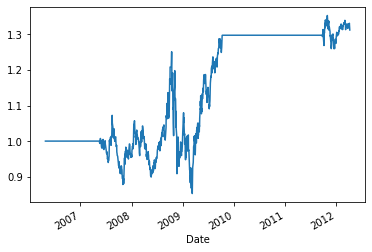

In [32]:
stock_df.cum_rets.plot()